In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist


original_dim = 1000
intermediate_dim = 512
latent_dim = 2
batch_size = 100
epochs = 100
epsilon_std = 1.0


In [2]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [3]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split


In [5]:
def splitw(x):
    return np.array([y for y in x])
#.replace('T','1'),replace('G','2').replace('C','3')

In [6]:
FILES=glob.glob('../../datasets/SEQUENCE_/HIV/*seq')
#! wc ../hwdata/hiv/*seq

In [7]:
data=pd.concat([pd.read_csv(i,header=None) for i in FILES])

data1=np.array([x for x in np.squeeze(data)])

data2=np.array([splitw(x.replace('A','1').replace('T','2').replace('G','3').replace('C','4')).astype(int) for x in data1])

data2.shape

(158,)

In [8]:
X=[]
dim1=158
for i in data2:
    X=np.append(X,i[:original_dim])
X=X.reshape(dim1,int(original_dim))
X=X/4.

In [9]:
y=np.array([0*np.ones(60),1*np.ones(37),2*np.ones(23),3*np.ones(38)])
y=np.squeeze(y)
YY=[]
for i in y:
    YY=np.append(YY,i)
YY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.])

In [10]:
x_train, x_test, y_train,  y_test=train_test_split(X,YY,test_size=.2)

In [11]:
x_test.shape

(32, 1000)

In [19]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

Train on 126 samples, validate on 32 samples
Epoch 1/100
126/126 [==============================] - 0s 446us/sample - loss: 627.1050 - val_loss: 641.6157
Epoch 2/100
126/126 [==============================] - 0s 523us/sample - loss: 628.6834 - val_loss: 652.9774
Epoch 3/100
126/126 [==============================] - 0s 457us/sample - loss: 640.7063 - val_loss: 649.9092
Epoch 4/100
126/126 [==============================] - 0s 468us/sample - loss: 633.5135 - val_loss: 645.4888
Epoch 5/100
126/126 [==============================] - 0s 604us/sample - loss: 629.9333 - val_loss: 645.4883
Epoch 6/100
126/126 [==============================] - 0s 513us/sample - loss: 629.3351 - val_loss: 641.7304
Epoch 7/100
126/126 [==============================] - 0s 513us/sample - loss: 626.9032 - val_loss: 644.7783
Epoch 8/100
126/126 [==============================] - 0s 561us/sample - loss: 629.3923 - val_loss: 645.8986
Epoch 9/100
126/126 [==============================] - 0s 445us/sample - loss: 628.

Epoch 75/100
126/126 [==============================] - 0s 535us/sample - loss: 617.7913 - val_loss: 642.7136
Epoch 76/100
126/126 [==============================] - 0s 607us/sample - loss: 628.8775 - val_loss: 646.2814
Epoch 77/100
126/126 [==============================] - 0s 572us/sample - loss: 626.8408 - val_loss: 635.7015
Epoch 78/100
126/126 [==============================] - 0s 589us/sample - loss: 617.7429 - val_loss: 636.6260
Epoch 79/100
126/126 [==============================] - 0s 541us/sample - loss: 618.2000 - val_loss: 641.8511
Epoch 80/100
126/126 [==============================] - 0s 571us/sample - loss: 625.4937 - val_loss: 642.9114
Epoch 81/100
126/126 [==============================] - 0s 539us/sample - loss: 624.3775 - val_loss: 635.4091
Epoch 82/100
126/126 [==============================] - 0s 569us/sample - loss: 618.6534 - val_loss: 636.1721
Epoch 83/100
126/126 [==============================] - 0s 546us/sample - loss: 617.8226 - val_loss: 636.7997
Epoch 84/1

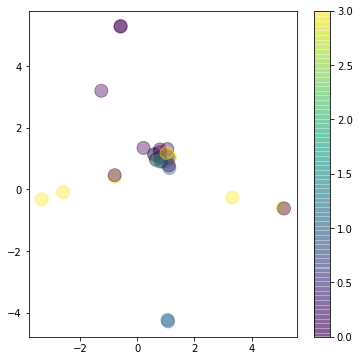

In [20]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=13**2, cmap='viridis')
plt.colorbar()


In [31]:
val=[4,.5]

In [32]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

'GTTTAGTCGTGGGGCGGCGTGGGGTGAGTACGCCAAAAATTTTGAGTTGCGGAGGCGAGAAGGAGAGAGATGGGTGGGTGTGCGTCAGTTTTTTGCGGGGGAGAGTTTTAAAGTTTGTAAATATTTGGGTTATGGCCTGGGGGTATGTTAGTTTTTTTATTATATCTGTTTGTATGGGCTTGCAGGGTTGTTGTGCGATTGGCTGTTAATGGTGGCCTGTTTGTTACTGCAGTAGGGTTTAGACTTTTTGTTGATCAGCTACAACCATCCCTTCAGAGAGTATCAGAAGTTGTTATATCTTTATATTTGTGAGTTGGATGGGTCTATTGTGTTCATGATAATATTGAGGTTTAAGTGTCCATGGAATGTTTAGTGTAGATAGTGGATGTCCAAAACAAATTTTAGAAATTTGGAGAGGAAGGAGCTGGGTGGTGTGTGTTGTGCAGCGTGGTGTGGCATATTTAGGGTATTGTTGATATGGTTGAGGTGCAATGGGGATTTGAGGGCTTTTGTGGATGATCTTTAATTGCAGGTTTAAATGTATTTGTATTTTAGGGTATGAGCGGATTAGTATTTGGGATTTTGTGTTGGTTTGGAGATGGTGGGTGGGGTGTTGTTGTTAAGAGGATCGTTAAGTGTTTGTGGGGTGTTGTTGGTGGGTTGGTTATGGTTAATGTGTGTTTGTTGGTTTATGGTGGATTATGGGATTTTTTGGTTGGTGTGGTTGCTGTTGCTTTTGGTGGAGGGCTTTTGTTTTATGGATTTGGATGTGTGTTTGGTTGTTGTAGTTGTAGGGTTGTGGTTCATTTTGGTTGGTTGTGTATTATTGGAGGTTTGGGTTTTGGAGATATGTTTATTTTTTTTATATGCTTGTTATTTATTTATATTTTTTTATGGTTTTTCGGGTGCTGGTTTGTGGTTATTTTTGAATTTCGATTGGTTGGGTTTTGTGATTATGTTGAGGGTTTCTATAATTGTGTAAGAGGGGTTGTTGGTTGA

In [33]:
val=[.5,.5]

In [26]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

'TGGTTTGTGTTTGGGGGTGGTTTTTTTGTGTTGTGTTGGTTTTTGTGTGGTGGGTTGTGTGTGTTGGGGTGTTGGGTGTTGTTGTTTTGTTGTGTGTTTGTGGTGGGTTGTGTTTTGGTGTGTGTTTTGTTTGGTGGTGGTTGGTTGGGGGTGTGGTGGGTGTGGTGTGTGTTTTGTGGTTTTTTGGTTTGTTGTTGTTTTTTGGTTTGTGTTTTTTGGTTGTTTTTTGGTTTTTTTGTTTGTTTTTTTGTTTTGTTTGTTTTTTTTTGTGTTTTTTTTGTTTTTGTTTGTTTTGGGTTTTTGTTGTTGGTTTTTTTTTGTTTTTGTTGTGTTTTTTTTTGTTGGTTTTTGGTGTGTGTTTGTTTTTTGGGGTTGGTTTTTTTGGTTTGGTGTTTTTTTGTTGTTTTGGGTTGGGTGTTTTTGTTGTTTTTTTTTGTGGTTTTGTTGTTTTTTGTTTTGTGTGTTTTTTTTGTTGTTTTTTTGGTTTTTTGTTGTTGTTTTTTTTTGTTTTGTTGTTTTTTTGTTTGTTTTTTTTTTTTGTTTTTTTGTTTTTTTTTTTTGTTGTTTTGTTTTGTTTTTTTTTTTTTTTTTTTTTTTTTTGTTGTTTTTTTTTTTTGTGTTTTTTTTTTGTTTGTTTTGTTGTGTTTTTTTGTGTTTTTTGTGTTTTTTTTTGTGTTTTTTTTTGTTGTTTGGTTTTTTTTTGTTGGTTTGTTGTTTTTTGTTTTTTTGGTTTTTGTGGTTTTTTTTTTTGGTGTTTTTTTTTTTTTTGTTTTTTTTTTTTTTTTTTTTTGGTTGTTTTTTGTTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGGTTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTGGTTTTTGTGTTTTTGGTTTTTTTTTTTTTGTTGGTTTTTTTTGTTTGTTTTTTTTTTGTTTTTTTTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTTTTTT

## HW:
---
    1. what are the hyper parameters you can tune?
    2. Tune the models so that the distribution is more compact.
    3. Investigate other segments (POL, ENV, INTEGRASE, Reverse-transcriptase, and complete genome)
    4. Blast it against the origin sequence data to investigate if we are closer to the clinical subtypes that we shpuld be closer to
    5. How well can we actually use this to generate new samples (sequences of hiv clinical subtypes not in the dataset?)